In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [2]:
tf.test.gpu_device_name()

''

In [3]:
epochs = 10
batch_size = 32
target_size = 224
seed = 1234

train_dir = "../skin_disease/train/"
val_dir = "../skin_disease/test/"

classes = ["Benign", "Malignant"]

np.random.seed(seed)

In [4]:
train_ds, val_ds = image_dataset_from_directory(
    train_dir,
    image_size = (target_size, target_size),
    batch_size = batch_size,
    label_mode = "binary",
    validation_split = 0.2,
    subset = "both",
    seed = seed
)

# Load test images
test_ds = image_dataset_from_directory(
    val_dir,
    image_size = (target_size, target_size),
    batch_size = batch_size,
    label_mode = "binary",
    seed = seed
)

Found 11879 files belonging to 2 classes.
Using 9504 files for training.
Using 2375 files for validation.
Found 2000 files belonging to 2 classes.


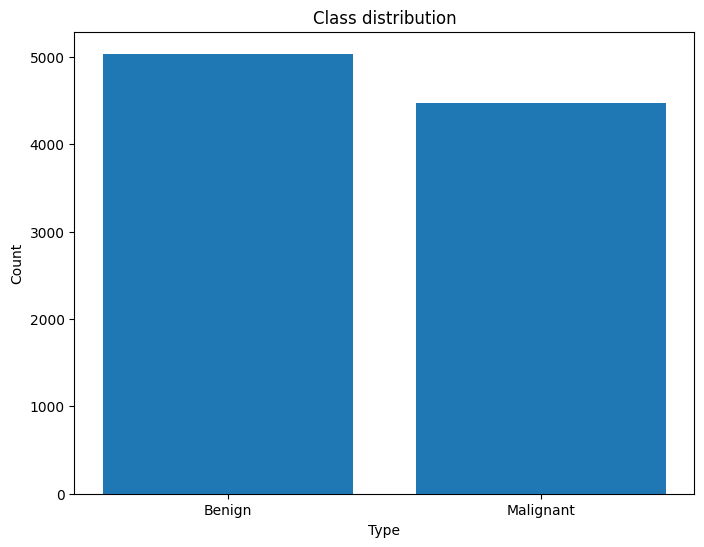

In [5]:
class_counts = {'Benign': 0, 'Malignant': 0}

# Iterate over dataset, for each batch iterate the single images
# and increment the value of the correct class
for images, labels in train_ds:
    for label in labels:
        class_name = 'Malignant' if label == 1 else 'Benign'
        class_counts[class_name] += 1

# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Class distribution')
plt.show()

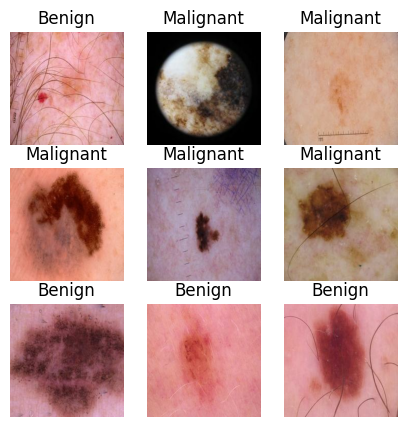

In [6]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(classes[int(labels[i])])
        plt.axis("off")

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip(),
        layers.RandomRotation(0.1),
        layers.RandomBrightness(0.1),
    ]
)

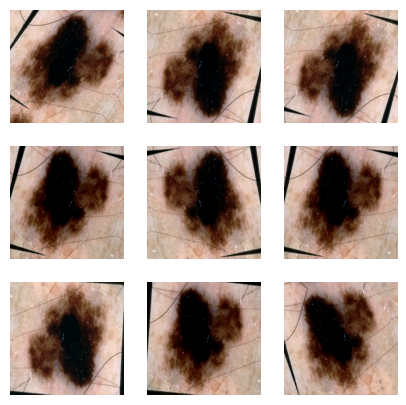

In [8]:
plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
    for i in range(9):
        aug_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(aug_images[0]).astype("uint8"))
        plt.axis("off")

In [9]:
lr = 1e-5
epochs = 30
opt = Adam(learning_rate=lr)
dropout_rate = 0.4
cur_loss = keras.losses.BinaryFocalCrossentropy()

In [10]:
vgg = keras.applications.vgg16.VGG16(
            weights="imagenet",
            include_top=False,
            input_shape=(target_size, target_size, 3))
vgg.trainable = False

58889256/58889256 [==============================] - 9s 0us/step


In [11]:
inputs = keras.Input(shape=(target_size, target_size, 3))
x = data_augmentation(inputs)
x = keras.layers.Lambda(lambda x: keras.applications.vgg16.preprocess_input(x))(x)
x = vgg(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [12]:
model.compile(loss=cur_loss,
              optimizer=opt,
              metrics=['accuracy'])